In [83]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from functools import partial
import pandas as pd
from IPython.display import display
import ipywidgets as widgets

## Control of oscillations (OOP version)

In [84]:
#calc_others(sol, consts)
class oscillation:
    def __init__(self, model, params, consts, calc_all):

        #Model and parameters
        self.__model = model
        self.__params = params
        self.__consts = consts
        self.__calc_all = calc_all

        #Essential information
        self.__species = ['A2', 'S_total', 'A', 'O']
        self.__info = None

        #Experimental data
        self.__exp_data = None

    @property
    def info(self):
        print(f'The model includes {len(self.__params)} parameters and {len(self.__consts)} constants. The species are {self.__species}.')
        print(f'Additional information: {self.__info}')

    def add_info(self, info):
        self.__info = info
        
    def simulate(self, init_cond, t=10, t_eval = 'default'):
        params_pass = np.hstack((self.__params, self.__consts))
        model_partial = partial(self.__model, params = params_pass)
        t_span = (0, t)

        if type(t_eval) == str:
            t_eval = np.linspace(0, t, 500)
        sol = solve_ivp(model_partial, t_span = t_span, y0 = init_cond, t_eval = t_eval, rtol=1e-6, atol=1e-8)
        return sol
    
    def plot(self, init_cond, t=10, exp=False):
        sol = self.simulate(init_cond, t)
        c = self.__calc_all(sol, self.__consts)
        fig, ax = plt.subplots(2, 2, figsize = (10,6))
        i = 0
        for ax, y in zip(ax.flatten(), c):
            ax.plot(sol.t, y, label = self.__species[i])
            ax.legend()
            i += 1
        return fig, ax
    
    def interactive_plot(self, init_cond, t=10, range = 5, step=0.05):
        
        if len(self.__params) == 4:
            print('4 parameters')
            def plot_temp(alpha, beta, theta, phi):
                params_old = self.__params
                params = [alpha, beta, theta, phi]
                self.__params = params
                self.plot(init_cond, t)
                self.__params = params_old
            
            alpha, beta, theta, phi = self.__params
            alpha_slider = widgets.FloatSlider(value=alpha, min=max(0, alpha-range), max=alpha+range, step=step, description='alpha')
            beta_slider = widgets.FloatSlider(value=beta, min=max(0, beta-range), max=beta+range, step=step, description='beta')
            theta_slider = widgets.FloatSlider(value=theta, min=max(0, theta-range), max=theta+range, step=step, description='theta')
            phi_slider = widgets.FloatSlider(value=phi, min=max(0, phi-range), max=phi+range, step=step, description='phi')

            interactive_widget = widgets.interactive(plot_temp, alpha=alpha_slider, beta=beta_slider, theta=theta_slider, phi=phi_slider)
            display(interactive_widget)

        elif len(self.__params) == 5:
            print('5 parameters')
            pass

    def add_exp_data(self, exp_data):
        print(f'The species are {self.__species}. Please check if the data is in the same order and correct format (time, concentration).')
        data = exp_data.clip(lower=0)
        self.__exp_data = data

    def set_params(self, params):
        self.__params = params

    def fit(self):
        tA2 = np.array(self.__exp_data.iloc[:, 0])
        cA2 = np.array(self.__exp_data.iloc[:, 1])
        tS = np.array(self.__exp_data.iloc[:, 2])
        cS = np.array(self.__exp_data.iloc[:, 3])

        if self.__exp_data.shape[1] >= 4:
            tA = np.array(self.__exp_data.iloc[:, 4])
            cA = np.array(self.__exp_data.iloc[:, 5])
        
        t_span_A2 = tA2[-1]
        t_span_S = tS[-1]
        init_cond = [cA2[0], cS[0]]

        def objective(params):
            params_old = self.__params
            self.__params = params
            simA2 = self.simulate(init_cond, t=t_span_A2, t_eval=tA2)
            simS = self.simulate(init_cond, t=t_span_S, t_eval=tS)
            print(self.__params)
            c_all_A2 = self.__calc_all(simA2, self.__consts)
            c_all_S = self.__calc_all(simS, self.__consts)

            obj = np.sum((c_all_A2[0] - cA2)**2 + (c_all_S[1] - cS)**2)

            return obj
        
        opt_result = sp.optimize.minimize(objective, self.__params, method='Nelder-Mead', tol=1e-6, options={'disp': True})
        return opt_result.x


In [85]:
#Params includes alpha, beta, theta, phi, lam, m in the final model

def model1(t, vars, params):
    alpha, beta, theta, phi, lam, m = params
    C_A2, C_S = vars
    dC_A2dt = 1 - alpha * C_A2 * C_S**m - theta * C_A2
    dC_Sdt = alpha/lam * C_A2 * C_S**m - beta * C_S**(m + 1) + theta/lam * C_A2 - phi * C_S
    return (dC_A2dt, dC_Sdt)

def model1_Hill(t, vars, params):
    pass

def calculate_all_conc(sol, consts):
    lam, m = consts
    C_A2 = sol.y[0]
    C_S = sol.y[1]
    C_M = C_S ** m
    C_A = 2 * (1 - C_A2) - lam * (C_S + C_M)
    C_O = 1 / (2 * (1 - C_A2) - lam * (C_S + C_M)) ** 2
    return (C_A2, C_S + C_M, C_A, C_O)

In [86]:
params = [24.3, 1.14, 3.09, 10.67]
consts = [0.17, 4]
init_cond = [0.1, 0]

model_test = oscillation(model1, params, consts, calculate_all_conc)

In [87]:
model_test.add_info('This is a test model. The original Fernando\'s model')
model_test.info

The model includes 4 parameters and 2 constants. The species are ['A2', 'S_total', 'A', 'O'].
Additional information: This is a test model. The original Fernando's model


In [88]:
df_c1 = pd.read_csv(r'Data_sets/1_expB_osc_NatChem_MH.csv')
df_c3b = pd.read_csv(r'Data_sets/3b_expB_osc_NatChem_MH.csv')
df_c4 = pd.read_csv(r'Data_sets/4_expB_osc_NatChem_MH.csv')
exp_data = pd.concat([df_c1, df_c3b, df_c4], axis=1)
exp_data.columns = ['t1', 'c1','t3b', 'c3b', 't4', 'c4']
exp_data = exp_data.drop_duplicates(subset=['t1'])
exp_data = exp_data.drop_duplicates(subset=['t3b'])
exp_data = exp_data.drop_duplicates(subset=['t4'])
model_test.add_exp_data(exp_data)

The species are ['A2', 'S_total', 'A', 'O']. Please check if the data is in the same order and correct format (time, concentration).


(<Figure size 1000x600 with 4 Axes>, <Axes: >)

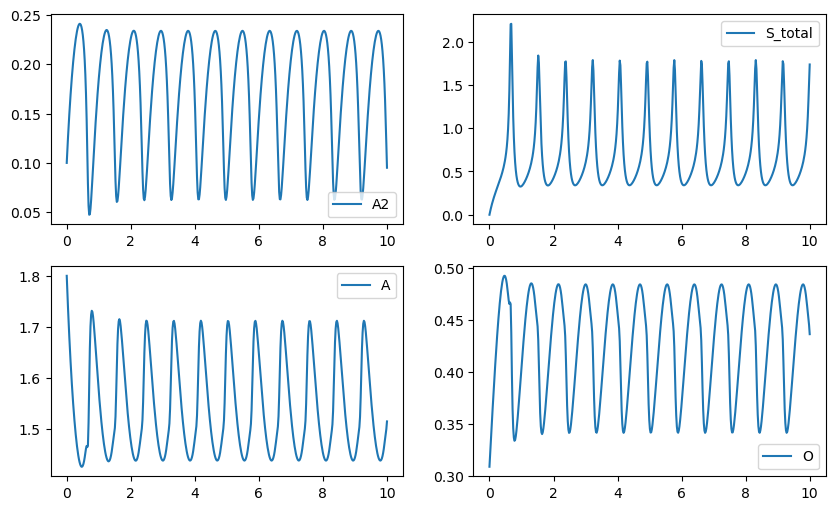

In [89]:
model_test.plot((0.1, 0))

In [91]:
model_test.fit()

[-392.34827078   -1.55585272   31.51231935   11.72593979]
[-411.96568432   -1.55585272   31.51231935   11.72593979]
[-392.34827078   -1.63364536   31.51231935   11.72593979]
[-392.34827078   -1.55585272   33.08793531   11.72593979]
[-392.34827078   -1.55585272   31.51231935   12.31223678]
[-402.15697755   -1.59474904   32.30012733   11.1396428 ]
[-394.80044747   -1.5655768    31.70927134   12.01908828]
[-399.70480086   -1.58502496   32.10317533   11.43279129]
[-396.02653582   -1.57043884   31.80774734   11.87251403]
[-374.56998976   -1.6020421    32.44784133   11.79922691]
[-402.61676068   -1.56740007   31.74619984   11.74426157]
[-399.32164825   -1.60781577   30.20135762   11.8083878 ]
[-394.09161515   -1.56884348   32.36629089   11.74655179]
[-394.67592288   -1.59243197   31.76081737   11.59883243]
[-395.68888259   -1.57593712   31.79601485   11.80409363]
[-384.62175897   -1.59973928   31.84727237   11.75700093]
[-398.11801025   -1.57548487   31.77146797   11.74744641]
[-395.16010205

KeyboardInterrupt: 